# Avazu CTR Prediction- Boosting Models

The most perfomant boosting model was XGboost with kfold cross validation scoring 0.744895 AUC. 

## Imports

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import sklearn
import matplotlib.dates as mdates
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

### Ignore Warnings

In [2]:
'''Ignore Warning Messages'''
import warnings
warnings.filterwarnings('ignore')

### Matplotlib Style

In [3]:
'''Set style to GGplot for asthetics'''
matplotlib.style.use('ggplot')


### Sample and Import Dataset

In [6]:
''' Sample from Training Data down to 1 million records'''

n = 40428966  #total number of records in the dataset 
sample_size = 10000
skip_values = sorted(random.sample(range(1,n), n-sample_size)) 

#Tracking the indices of rows to be skipped at random

In [7]:
df = pd.read_csv('https://bidtime.s3.amazonaws.com/Avazu/train/train.gz', compression='infer', skiprows = skip_values)

In [8]:
df.to_csv('avazu_sample_10k.csv')

## Data Prepation

### Date Time conversion with Hour feature

In [9]:
def datesplit(originalDate):
    originalDate = str(originalDate)
    
    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])
    
    return datetime.datetime(year, month, day, hour)

### Create weekday and datetime from hour

In [10]:
df['weekday'] = df['hour'].apply(lambda x : datesplit(x).weekday()) 

In [11]:
df['hour'] = df['hour'].apply(lambda x : datesplit(x).hour)

### Vizualizations

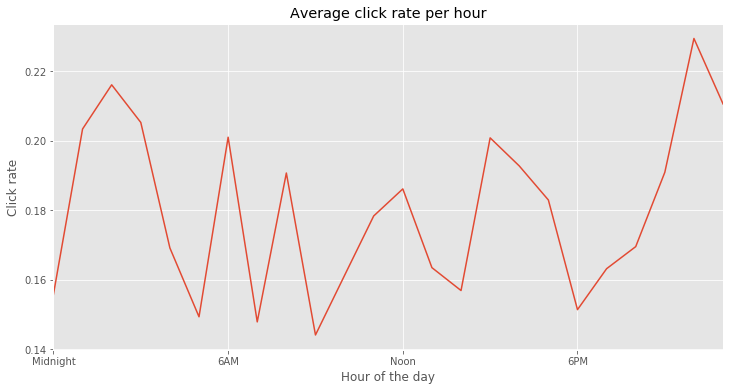

In [12]:
plt.figure(figsize=(12,6))
plt.plot(df.groupby(df['hour'])['click'].mean())
plt.xlabel("Hour of the day")
plt.ylabel("Click rate")
plt.title("Average click rate per hour")
plt.xticks(np.arange(0, 23, step=6), ('Midnight', '6AM', 'Noon', '6PM'))
plt.xlim([0.0, 23.0])
plt.show()

Users click on ads the most around 1 AM, 7AM, and 3PM.
They click on ads the least around 4AM, 9AM, and 8 PM.

This suggests that the best time to run ads for maximum impressions is just after midnight, but not too late, early in the morning but before the work commute begins, and in the afternoon. This maps well with when workers are least prodcutive at work, the afternoon. During the evening users may be engaging in activities outside of a screen, but later at night they are back on the internet.

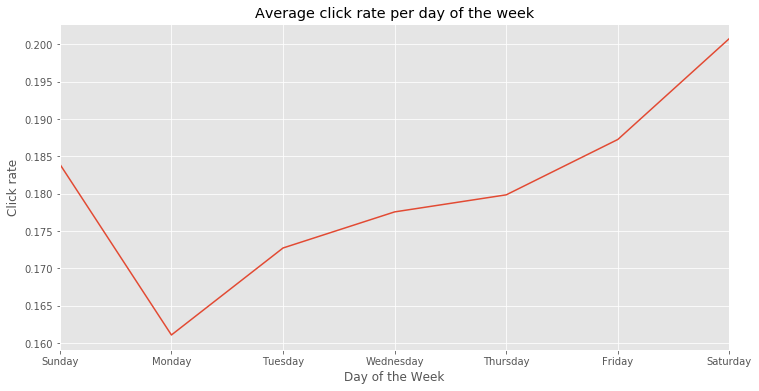

In [13]:
plt.figure(figsize=(12,6))
plt.plot(df.groupby(df['weekday'])['click'].mean())
plt.xlabel("Day of the Week")
plt.xticks(np.arange(0, 7, step=1), ('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',))
plt.xlim([0.0, 6.0])
plt.ylabel("Click rate")
plt.title("Average click rate per day of the week")
plt.show()

Users click on ads the most on the weekend, which suggests that when users have free time, they are spending it online. Tuesday and Monday are the worst days for ads, and as we get closer to the weekend, click rates improve.

### Variable Encoding

In [14]:
model_features = ['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 
                'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21']

In [15]:
model_target = 'click'

In [16]:
train_model = df[model_features+[model_target]]

In [17]:
train_model = df[model_features+[model_target]]

In [18]:
def one_hot_features(data_frame, feature_set):
    new_data_frame = pd.get_dummies(data_frame,
                                     columns = feature_set,
                                    sparse = True)

    return new_data_frame

In [19]:
train_model = one_hot_features(train_model, ['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'])

In [20]:
model_features = np.array(train_model.columns[train_model.columns!=model_target].tolist())

In [21]:
X = train_model[model_features].values

In [22]:
y = train_model[model_target].values

### Test Train Splt

In [23]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1,
                                                 random_state=100)

## Modeling

### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
hard = lr.predict(Xtest)
soft = lr.predict_proba(Xtest)

In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(ytest, soft[:,1]) 

#### Plot the roc curve

In [27]:
from sklearn.metrics import roc_auc_score
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

The ROC AUC is : 0.7122579882972662


NameError: name 'lw' is not defined

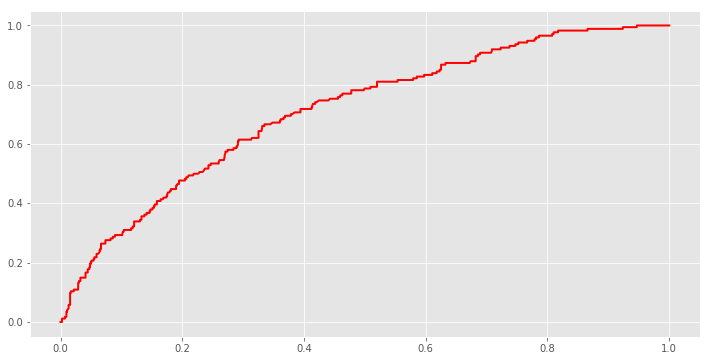

In [28]:
plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, color='red', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear Regression ROC Curve')
plt.show()

In [ ]:
lr_report = print(str(classification_report(ytest, hard)))

### Confusion Matrix

In [ ]:
y_pred = lr.predict(Xtest)
predictions = [round(value) for value in y_pred]

In [ ]:
from sklearn import metrics

print(confusion_matrix(ytest, predictions))

### Add site and user

In [ ]:
values = df['device_id'].value_counts().idxmax() 

df['user'] = np.where(df['device_id'] == values, df['device_ip'] + df['device_model'], df['device_id']) 

In [ ]:
df = df.drop(['device_id', 'device_model', 'device_ip'], axis=1) 


In [ ]:
df['site'] = df['site_id'] + df['site_domain'] 


In [ ]:
df = df.drop(['site_id', 'site_domain'], axis=1)


### Create another test train split

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=100)

In [ ]:
n_ones = np.array(Xtrain.sum(axis=0))


In [ ]:
useful = n_ones > 100 


In [ ]:
import collections
collections.Counter(useful)

In [ ]:
cols_to_keep = [i*b for i,b in enumerate(useful) if b == True]


In [ ]:
Xtrain = Xtrain[:,cols_to_keep] 

In [ ]:
Xtest = Xtest[:,cols_to_keep]


### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=50, learning_rate = 0.8, verbose=True) 
gb.fit(Xtrain, ytrain)

In [ ]:
hard = gb.predict(Xtest)
soft = gb.predict_proba(Xtest)
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, color='red', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC Curve')
plt.show()

In [ ]:
gb1_report = print(str(classification_report(ytest, hard)))

In [ ]:
y_pred = gb.predict(Xtest)
predictions = [round(value) for value in y_pred]
print(confusion_matrix(ytest, predictions))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=50, learning_rate = 0.8, verbose=False,) 
gb.fit(Xtrain, ytrain)

In [ ]:
hard = gb.predict(Xtest)
soft = gb.predict_proba(Xtest)
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, color='red', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC Curve')
plt.show()

In [ ]:
gb2_report = print(str(classification_report(ytest, hard)))

### Create leaves from gradient boosting

In [ ]:
leaves_train = gb.apply(Xtrain)[:,:,0] 
leaves_test = gb.apply(Xtest)[:,:,0] 

In [ ]:
leaves_train = pd.DataFrame(leaves_train) 
leaves_test = pd.DataFrame(leaves_test)

### Encoding

In [ ]:
encoder = OneHotEncoder(handle_unknown = 'ignore') 
leaves_train_encoded = encoder.fit_transform(leaves_train)
leaves_test_encoded = encoder.transform(leaves_test)

In [ ]:
from scipy.sparse import csr_matrix, hstack
Xtrain_hstack = hstack([ Xtrain, leaves_train_encoded]) 

In [ ]:
Xtest_hstack = hstack([ Xtest, leaves_test_encoded])

### Logistic Regression on new data

In [ ]:
lr = LogisticRegression()
lr.fit(Xtrain_hstack, ytrain)
lr.predict(Xtest_hstack)
soft = gb.predict_proba(Xtest)
roc_auc_score(ytest, soft[:,1])

### XGBoost

In [ ]:
#!pip install xgboost-for first time running
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators = 50,n_jobs = -1,learning_rate = 0.8)
xgb.fit(Xtrain_hstack, ytrain)

In [ ]:
xgb.predict(Xtrain_hstack)
soft = xgb.predict_proba(Xtest_hstack)
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

In [ ]:
y_pred = xgb.predict(Xtest_hstack)
predictions = [round(value) for value in y_pred]
print(confusion_matrix(ytest, predictions))

## Hashing

### Create new test train split

In [ ]:
X = df.drop(['click'], axis=1)
y = df['click']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=100)

### Hashing Function

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class MergeRareTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_names, threshold):
        self.col_names = col_names
        self.threshold = threshold

    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        counts_dict_list = []
        
        for i in range(len(self.col_names)):
            serie = X[self.col_names[i]].value_counts()  # Series of each column
            rare_indexes = serie[serie<self.threshold[i]].index  # The indexes for least frequent features
            frequent_indexes = serie[serie>=self.threshold[i]].index  # The indexes for most frequent features
            dictionary = {x:'isRare' for x in rare_indexes}
            dictionary.update({x: str(x) for x in frequent_indexes})
            counts_dict_list.append(dictionary)   # Index for rare and most frequent
        self.counts_dict_list_ = counts_dict_list
        return self

    def transform(self, X):

        Xt = pd.DataFrame()
                
        for col, count_dict in zip(self.col_names, self.counts_dict_list_):
            Xt[col] = X[col].apply(lambda x:count_dict[x] if x in count_dict else 'isRare')
        # Represent the new features never observed and apply the count_dict to ther rest

        return Xt

In [ ]:
merged = MergeRareTransformer(col_names=Xtrain.columns, threshold=[20]*len(Xtrain.columns))
Xtrain_merged = merged.fit_transform(Xtrain)
Xtest_merged = merged.transform(Xtest)

### Test Hash

In [ ]:
import hashlib
hash('test hash') 

### Hash the Dataframe

In [ ]:
Xtrain_hashed = pd.DataFrame()
Xtest_hashed = pd.DataFrame()
for col in Xtrain_merged.columns:
    Xtrain_hashed[col] = Xtrain_merged[col].apply(lambda x : hash(str(x)) % 1000000) 
    Xtest_hashed[col] = Xtest_merged[col].apply(lambda x : hash( str(x)) % 1000000)

### Log of hashed vs original feature dimentionality

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [ ]:
display(Xtrain.nunique()) 

display(Xtrain_hashed.nunique())

### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1024, min_samples_leaf = 20, verbose = False, n_jobs = -1)
rf.fit(Xtrain_hashed, ytrain)

In [ ]:
soft = rf.predict_proba(Xtest_hashed)


In [ ]:
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(ytest, soft[:,1])

In [ ]:
y_pred = rf.predict(Xtest_hashed)
predictions = [round(value) for value in y_pred]
print(confusion_matrix(ytest, predictions))

In [ ]:
random_forest_report = print(str(classification_report(ytest, predictions)))

### XGboost

In [ ]:
xgb = XGBClassifier(n_estimators = 1024,n_jobs = -1,learning_rate = 1)
xgb.fit(Xtrain_hashed, ytrain) 
soft = xgb.predict_proba(Xtest_hashed)
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

In [ ]:
y_pred = xgb.predict(Xtest_hashed)
predictions = [round(value) for value in y_pred]
print(confusion_matrix(ytest, predictions))

In [ ]:
fpr, tpr, thresholds = roc_curve(ytest, soft[:,1]) 

In [ ]:
xgboost_report = print(str(classification_report(ytest, predictions)))

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, color='red', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGboost ROC Curve')
plt.show()

In [ ]:
xgb = XGBClassifier(n_estimators = 1000, n_jobs = -1,learning_rate = .5, min_child_weight= 100, monotone_constraints='(0)')
xgb.fit(Xtrain_hashed, ytrain) 
soft = xgb.predict_proba(Xtest_hashed)
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

In [ ]:
print(str(classification_report(ytest, predictions)))

### Cross validation-best cv-With and without early stopping

In [ ]:
d_train = xgb.DMatrix(Xtrain_hashed, ytrain)
d_valid = xgb.DMatrix(Xtest_hashed, ytest)

In [ ]:
# XGBoost parameters 1
params = {
    'n_estimators' : 1024,
    'n_jobs' : -1,
    'learning_rate' : 1,
    'eval_metric': 'auc'
}



In [ ]:
# Without early stopping, overfit model
bst_cv = xgb.cv(params, d_train, num_boost_round=10000, nfold=10, verbose_eval=100,  early_stopping_rounds=None, as_pandas=True)
    

In [ ]:
bst_cv.tail()

In [ ]:
bst_cv[['train-auc-mean', 'test-auc-mean']].plot();

In [ ]:
print(bst.eval(d_valid))

In [ ]:
# With early stopping. Use CV to find the best number of trees

bst_cv = xgb.cv(params, d_train, num_boost_round=1000, nfold=5, verbose_eval=100, early_stopping_rounds=10, as_pandas=True, )

In [ ]:
bst_cv[['train-auc-mean', 'test-auc-mean']].plot();

In [ ]:
bst = xgb.train(params, d_train, num_boost_round=60)


In [ ]:
print(bst.eval(d_valid))

## Partial Dependency 

In [ ]:
def partial_dependency(bst, X, y, feature):
    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """

    X_temp = X.copy()
    
    grid = np.linspace(start=np.percentile(X_temp[feature], 0.1),
                       stop=np.percentile(X_temp[feature], 99.5),
                       num=50)
    
    y_pred = np.zeros(len(grid))

    for i, value in enumerate(grid):
        X_temp[feature] = value
        data = xgb.DMatrix(X_temp)
        y_pred[i] = np.average(bst.predict(data, ntree_limit=bst.best_ntree_limit))

    plt.plot(grid, y_pred, '-', color='red', linewidth=2.5)
    plt.plot(X, y, 'o', color='grey', alpha=0.01)
    plt.xlim(min(grid), max(grid))
    plt.xlabel(feature)
    plt.ylabel(y.name)
    plt.show()


In [ ]:
features = list(Xtrain_hashed)

In [ ]:
print(params['learning_rate'])

partial_dependency(bst, Xtrain_hashed[features], ytrain, feature='site')

In [ ]:
partial_dependency(bst, Xtrain_hashed[features], ytrain, feature='user')

In [ ]:
partial_dependency(bst, Xtrain_hashed[features], ytrain, feature='C15')

In [ ]:
partial_dependency(bst, Xtrain_hashed[features], ytrain, feature='hour')

In [ ]:
# todo-plot all the partial dependencies for bidding strategy

## Work in progress- K Folds

In [ ]:
kfold = 2
skf = StratifiedKFold(n_splits=kfold, random_state=65)

In [ ]:
# XGBoost parameters
params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

In [ ]:
models_by_fold = []

In [ ]:
#Kfold 1

from sklearn.model_selection import StratifiedKFold 
import xgboost as xgb
# Kfold training
for train_index, test_index in skf.split(X, y):
    
    # Convert data into XGBoost format.
    d_train = xgb.DMatrix(Xtrain_hashed, ytrain)
    d_valid = xgb.DMatrix(Xtest_hashed, ytest)
    
    # Watchlist to evaluate results while training.
    watchlist = [(d_train, 'train'), (d_valid, 'test')]

    # Training this fold
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=150, maximize=True, verbose_eval=100)
    
    # Add model to the list of models (one for each fold)
    models_by_fold.append(mdl)

# Best Performing Model-0.744895 AUC

In [ ]:
#kfold3

from sklearn.model_selection import StratifiedKFold 
import xgboost as xgb
# Kfold training
for train_index, test_index in skf.split(X, y):
    
    # Convert data into XGBoost format.
    d_train = xgb.DMatrix(Xtrain_hashed, ytrain)
    d_valid = xgb.DMatrix(Xtest_hashed, ytest)
    
    # Watchlist to evaluate results while training.
    watchlist = [(d_train, 'train'), (d_valid, 'test')]

    # Training this fold
    mdl = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=150, maximize=True, verbose_eval=100)
    
    # Add model to the list of models (one for each fold)
    models_by_fold.append(mdl)

In [ ]:
# XGBoost parameters 2
params = {
    'n_estimators' : 1024,
    'n_jobs' : -1,
    'learning_rate' : 1,
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

In [ ]:
models_by_fold = []

In [ ]:
#kfold 3
from sklearn.model_selection import StratifiedKFold 
import xgboost as xgb
# Kfold training
for train_index, test_index in skf.split(X, y):
    
    # Convert data into XGBoost format.
    d_train = xgb.DMatrix(Xtrain_hashed, ytrain)
    d_valid = xgb.DMatrix(Xtest_hashed, ytest)
    
    # Watchlist to evaluate results while training.
    watchlist = [(d_train, 'train'), (d_valid, 'test')]

    # Training this fold
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=150, maximize=True, verbose_eval=100)
    
    # Add model to the list of models (one for each fold)
    models_by_fold.append(mdl)

In [ ]:
#kfold 4
from sklearn.model_selection import StratifiedKFold 
import xgboost as xgb
# Kfold training
for train_index, test_index in skf.split(X, y):
    
    # Convert data into XGBoost format.
    d_train = xgb.DMatrix(Xtrain_hashed, ytrain)
    d_valid = xgb.DMatrix(Xtest_hashed, ytest)
    
    # Watchlist to evaluate results while training.
    watchlist = [(d_train, 'train'), (d_valid, 'test')]

    # Training this fold
    mdl = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=150, maximize=True, verbose_eval=100)
    
    # Add model to the list of models (one for each fold)
    models_by_fold.append(mdl)

In [ ]:
# XGBoost parameters 2
params = {
    'n_estimators' : 1024,
    'n_jobs' : -1,
    'learning_rate' : 1,
    'eval_metric': 'auc'
}

In [ ]:
models_by_fold = []

In [ ]:
from sklearn.model_selection import StratifiedKFold 
import xgboost as xgb
# Kfold training
for train_index, test_index in skf.split(X, y):
    
    # Convert data into XGBoost format.
    d_train = xgb.DMatrix(Xtrain_hashed, ytrain)
    d_valid = xgb.DMatrix(Xtest_hashed, ytest)
    
    # Watchlist to evaluate results while training.
    watchlist = [(d_train, 'train'), (d_valid, 'test')]

    # Training this fold
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=150, maximize=True, verbose_eval=100)
    
    # Add model to the list of models (one for each fold)
    models_by_fold.append(mdl)

In [ ]:
n_folds = 5
early_stopping = 10
params = {'eta': 0.02, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'objective': 'binary:logistic', 'seed': 99, 'silent': 1, 'eval_metric':'auc', 'nthread':4}

xg_train = xgb.DMatrix(Xtrain_hashed, label=y_train);

cv = xgb.cv(params, xg_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)